In [ ]:
import pandas as pd
import numpy as np
import string
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from wordcloud import WordCloud

In [ ]:
df = pd.read_csv('../Data/bbc-text.csv')
print('The shape of dataframe is:', df.shape)
print(df.head())

The shape of dataframe is: (2225, 2)
        category                                               text
0           tech  tv future in the hands of viewers with home th...
1       business  worldcom boss  left books alone  former worldc...
2          sport  tigers wary of farrell  gamble  leicester say ...
3          sport  yeading face newcastle in fa cup premiership s...
4  entertainment  ocean s twelve raids box office ocean s twelve...


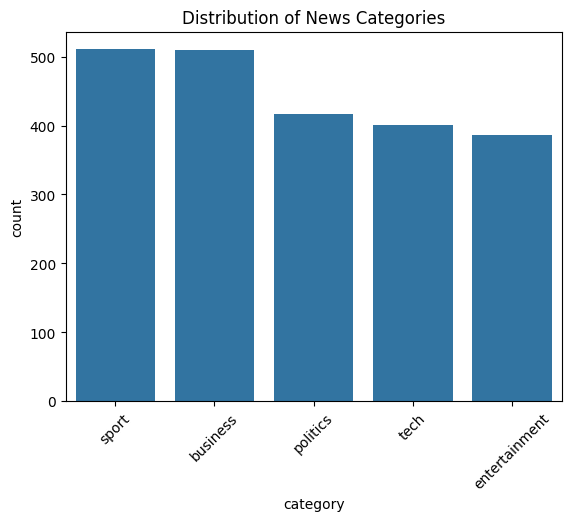

In [39]:
sns.countplot(data=df, x='category', order= df['category'].value_counts().index)
plt.title("Distribution of News Categories")
plt.xticks(rotation=45)
plt.show()

In [40]:


# Initialize objects
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()


def preprocess_text(text):
    # Check if text is a string (handles missing data/NaN)
    if not isinstance(text, str):
        return ""

    # 1. Convert to lower case
    text = text.lower()

    # 2. Tokenize
    # We tokenize before removing punctuation so we don't accidentally merge words (e.g., "hello-world")
    tokens = word_tokenize(text)

    # List to hold the cleaned tokens
    cleaned_tokens = []

    for token in tokens:
        # 3. Remove Punctuation & 4. Remove Stop Words
        if token not in string.punctuation and token not in stop_words:
            
            # 5. Lemmatization
            # Note: We use the lemmatizer defined in your snippet, not the stemmer.
            lemma = lemmatizer.lemmatize(token)
            cleaned_tokens.append(lemma)

    # Join the tokens back into a single string for the DataFrame
    return " ".join(cleaned_tokens)

# Assuming 'df' is your DataFrame
df['preprocessed_text'] = df['text'].apply(preprocess_text)
df[['text', 'preprocessed_text']].head()

,text,preprocessed_text
0,tv future in the hands of viewers with home th...,tv future hand viewer home theatre system plas...
1,worldcom boss left books alone former worldc...,worldcom bos left book alone former worldcom b...
2,tigers wary of farrell gamble leicester say ...,tiger wary farrell gamble leicester say rushed...
3,yeading face newcastle in fa cup premiership s...,yeading face newcastle fa cup premiership side...
4,ocean s twelve raids box office ocean s twelve...,ocean twelve raid box office ocean twelve crim...


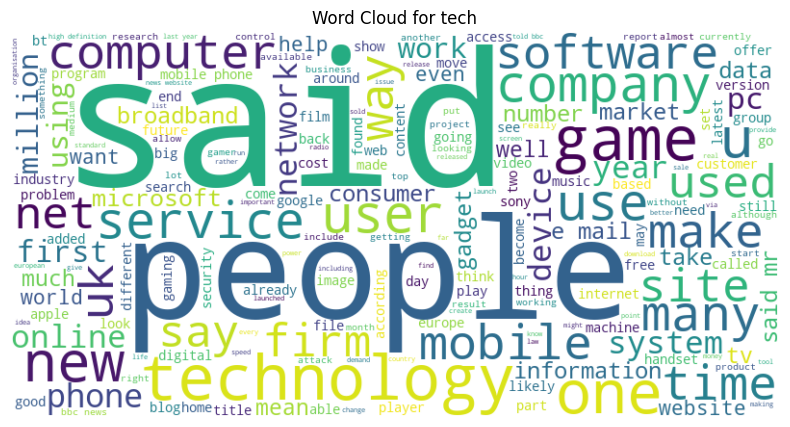

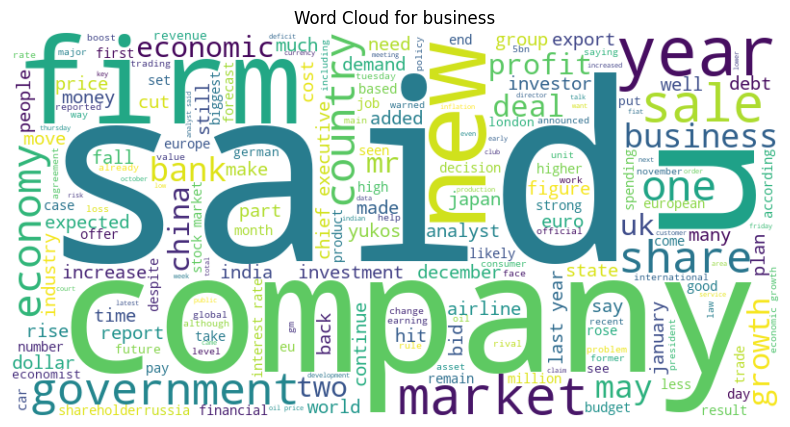

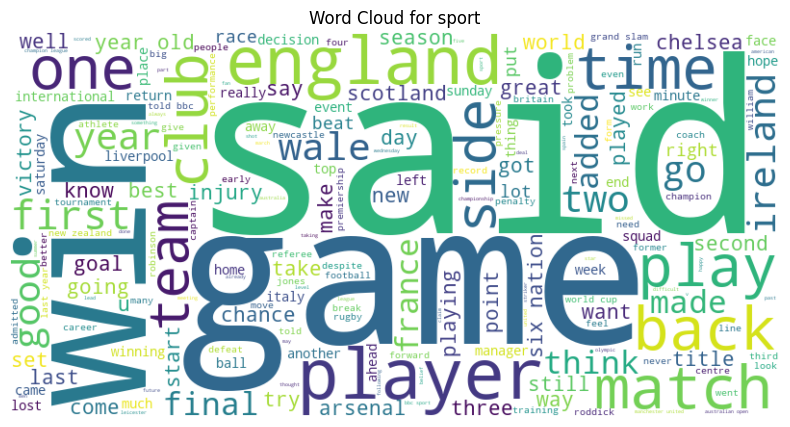

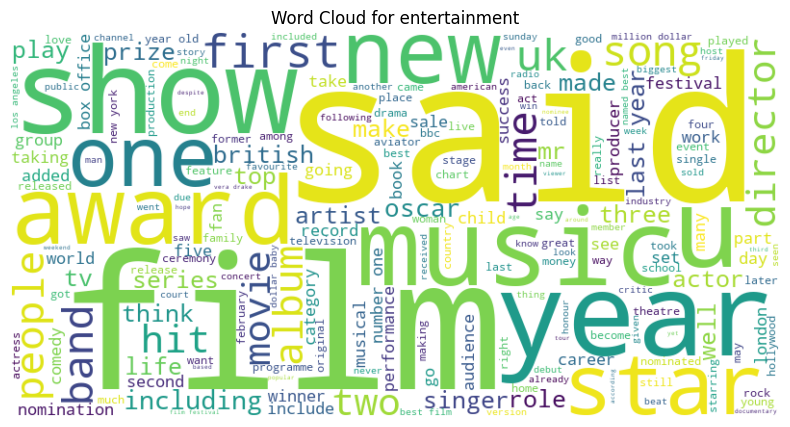

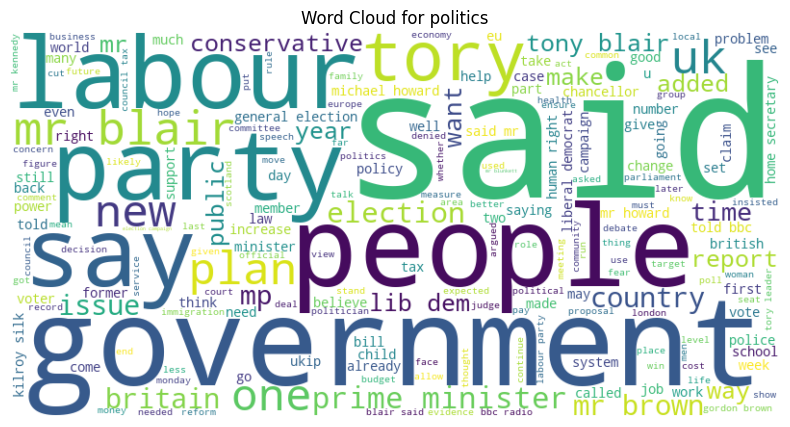

In [41]:


# Loop through each unique category in the DataFrame
for category in df['category'].unique():
    
    # 1. Gather all text associated with this category into one long string
    category_text = " ".join(df[df['category'] == category]['preprocessed_text'])

    # Generate the Word Cloud
    # We define dimensions and background color for better visibility
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(category_text)
    
    plt.figure(figsize=(10, 5))
    
    plt.imshow(wordcloud, interpolation='bilinear')

    plt.title(f"Word Cloud for {category}")
    plt.axis('off')
    plt.show()

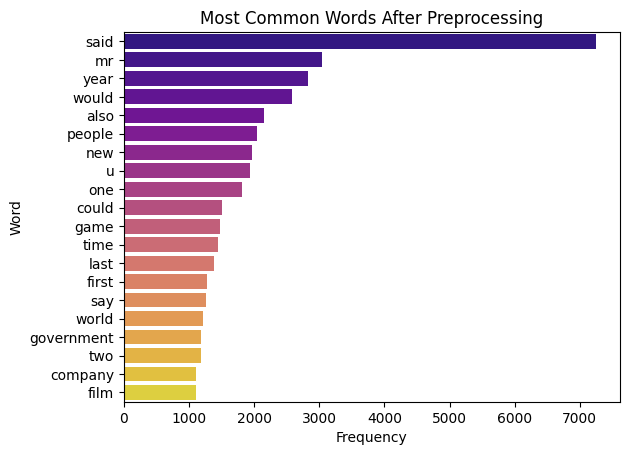

In [42]:
all_words = [word for text in df['preprocessed_text'] for word in text.split()]

word_freq = Counter(all_words)

most_common_words = word_freq.most_common(20)
common_df = pd.DataFrame(most_common_words, columns=['Word', 'Frequency'])

sns.barplot(data=common_df, x='Frequency', y='Word', palette='plasma', hue='Word')
plt.title("Most Common Words After Preprocessing")
plt.show()

Shape of the matrix (Rows = Number of Documents, Columns = Number of Unique Words) (2225, 26465)


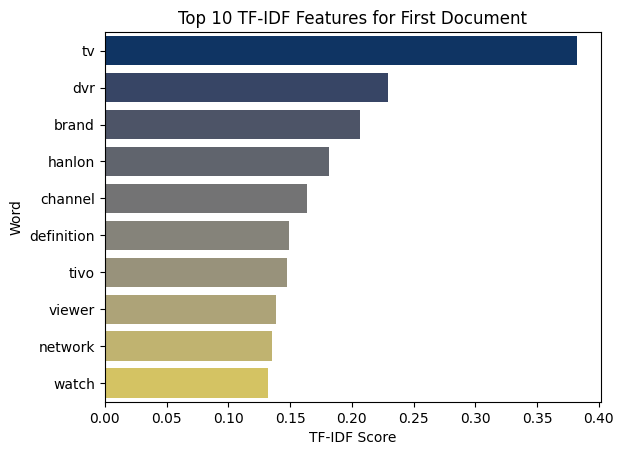

In [44]:
# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit the vectorizer to the data and transform the text into a matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(df['preprocessed_text'])

# Output the shape of the matrix (Rows = Number of Documents, Columns = Number of Unique Words)
print("Shape of the matrix (Rows = Number of Documents, Columns = Number of Unique Words)", tfidf_matrix.shape)


tfidf_sample = pd.DataFrame(tfidf_matrix[0].toarray().T, columns=["TF-IDF Score"])
tfidf_sample['Word'] = tfidf_vectorizer.get_feature_names_out()
tfidf_sample = tfidf_sample.sort_values(by="TF-IDF Score", ascending=False).head(10)

sns.barplot(data=tfidf_sample, x='TF-IDF Score', y='Word', palette='cividis', hue='Word')
plt.title("Top 10 TF-IDF Features for First Document")
plt.show()

In [51]:
label_encoder = LabelEncoder()

# Fit the encoder to the categories and transform them to numbers
df['category_encoded'] = label_encoder.fit_transform(df['category'])

# Display the mapping to check which number represents which category
print(df[['category', 'category_encoded']].drop_duplicates().sort_values('category_encoded'))


X = tfidf_matrix
y = df['category_encoded']

# TODO: Fill in X and y as the arguments
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Output the dimensions of the split data
print("Dimensions of the split data\n", "Train data:", X_train.shape, "\n Test data:", X_test.shape)


# Initialize the Random Forest Classifier
classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
classifier.fit(X_train, y_train)

        category  category_encoded
1       business                 0
4  entertainment                 1
5       politics                 2
2          sport                 3
0           tech                 4
Dimensions of the split data
 Train data: (1780, 26465) 
 Test data: (445, 26465)


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False



Classification Report:
               precision    recall  f1-score   support

     business       0.91      0.95      0.93       101
entertainment       1.00      0.91      0.95        81
     politics       0.94      0.95      0.95        83
        sport       0.98      0.99      0.98        98
         tech       0.94      0.94      0.94        82

     accuracy                           0.95       445
    macro avg       0.95      0.95      0.95       445
 weighted avg       0.95      0.95      0.95       445



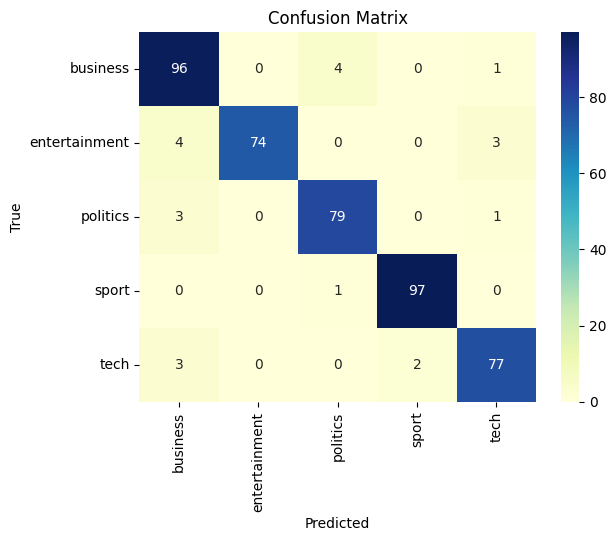

Overall Accuracy: 0.95


In [52]:
# Predict on the test data
y_pred = classifier.predict(X_test)

# Classification report to evaluate model performance
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion matrix to visualize model performance
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Calculate and print the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {accuracy:.2f}")
